In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def _parse_function(filename, size=640):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)

    cropped_image = tf.random_crop(image_decoded, size=[size, size, 3])

    image = cropped_image[:, :, 0]
    label = cropped_image[:, :, 1]

    return image, label


def _read_images(image_dir, crop_size, scale_by=0.66):
    filenames = tf.train.match_filenames_once(image_dir + "*.png")
    filename_queue = tf.train.string_input_producer(filenames)

    # create the reader
    image_reader = tf.WholeFileReader()

    # Read a whole file from the queue
    filename, image_file = image_reader.read(filename_queue)

    # decode the image
    raw_image = tf.image.decode_png(image_file)
    
    # figure out size of raw crop by dividing size by scale
    image_size = int(crop_size // scale_by)

    # crop the image
    raw_image = tf.random_crop(raw_image, size=[image_size, image_size, 3])

    # resize the image
    resized_image = tf.image.resize_images(raw_image, size=[crop_size, crop_size])

    # extract the image and label from the channels and resize them for convnet
    image = tf.reshape(resized_image[:, :, 0], [crop_size, crop_size, 1])
    label = tf.reshape(resized_image[:, :, 1], [crop_size, crop_size, 1])
    
    label = tf.cast(label, dtype=tf.int32)
    
    return image, label

def _scale_input_data(X, contrast=None, mu=104.1353, scale=255.0):
    # if we are adjusting contrast do that
    if contrast and contrast != 1.0:
        X_adj = tf.image.adjust_contrast(X, contrast)
    else:
        X_adj = X

    # cast to float
    if X_adj.dtype != tf.float32:
        X_adj = tf.cast(X_adj, dtype=tf.float32)

    # center the pixel data
    X_adj = tf.subtract(X_adj, mu, name="centered_input")

    # scale the data
    X_adj = tf.divide(X_adj, scale)

    return X_adj

In [5]:
batch_size = 16
size = 320
distort = False
image_size = 640
contrast = 0
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope('inputs') as scope:
        with tf.device('/cpu:0'):
            image, label = _read_images("./data/train_images/", size, scale_by=0.66)
            X_def, y_def = tf.train.batch([image, label], batch_size=batch_size)

            # image, label = read_and_decode_single_example(train_files, label_type=how, normalize=False, distort=False, size=640)
            # X_def, y_def = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000, seed=None, min_after_dequeue=1000)

            # Placeholders
            X = tf.placeholder_with_default(X_def, shape=[None, size, size, 1])
            y = tf.placeholder_with_default(y_def, shape=[None, size, size, 1])

            X_fl = tf.cast(X, tf.float32)

            # optional online data augmentation
            if distort:
                X_dis, y_adj = augment(X_fl, y, horizontal_flip=True, augment_labels=True, vertical_flip=True, mixup=0)
            else:
                y_adj = y
                X_dis = X_fl

            # cast to float and scale input data
            X_adj = _scale_input_data(X_dis, contrast=contrast, mu=127.0, scale=255.0)
        
print("Graph created...")        

Graph created...


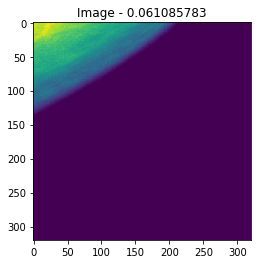

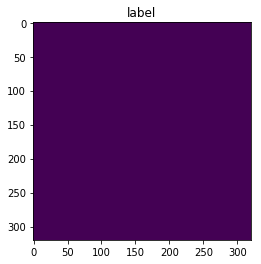

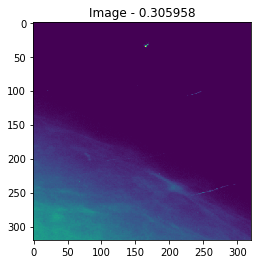

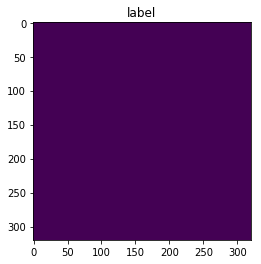

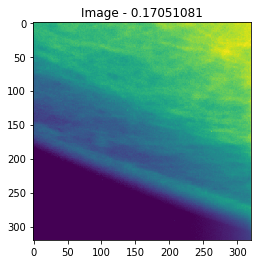

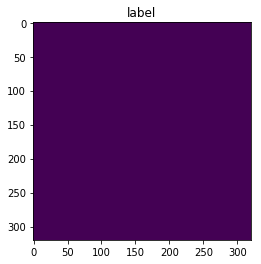

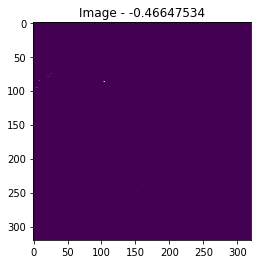

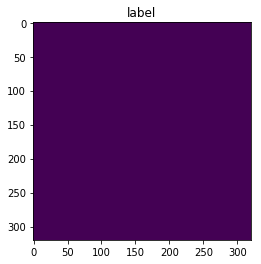

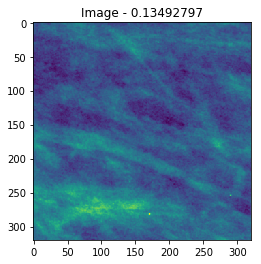

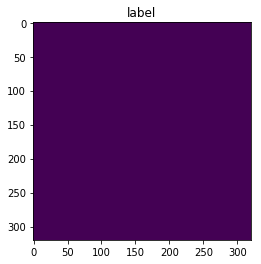

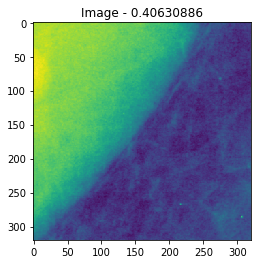

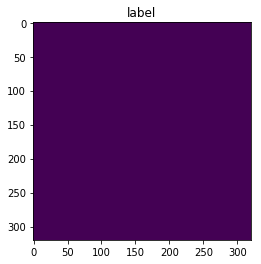

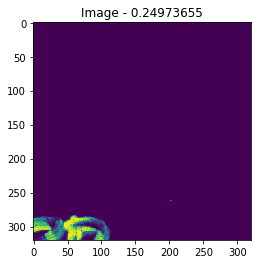

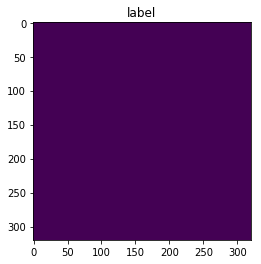

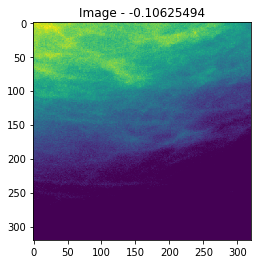

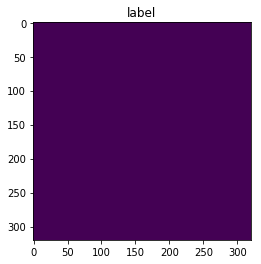

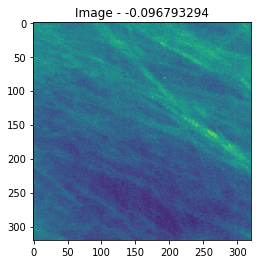

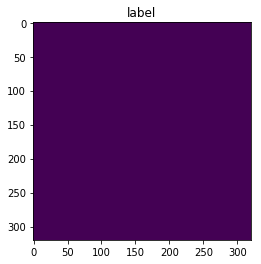

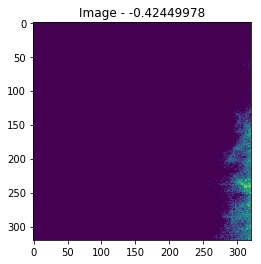

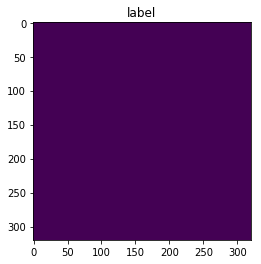

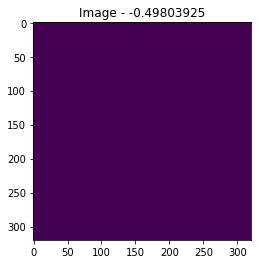

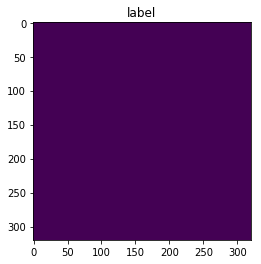

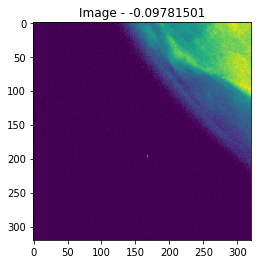

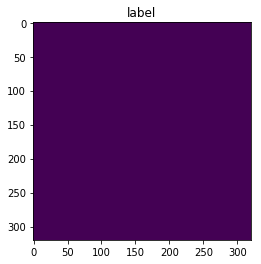

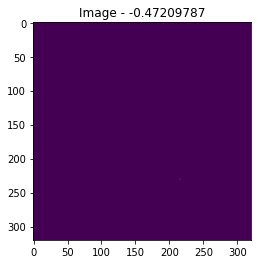

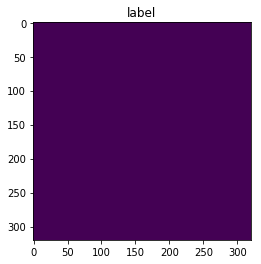

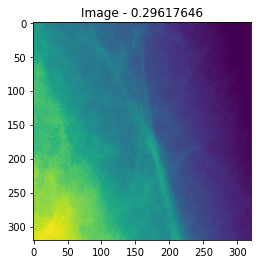

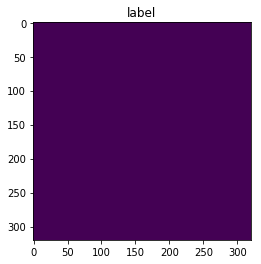

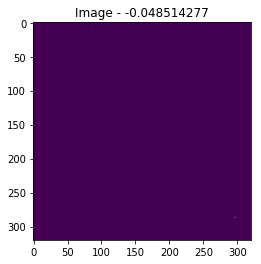

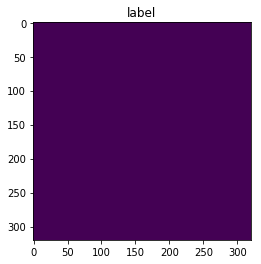

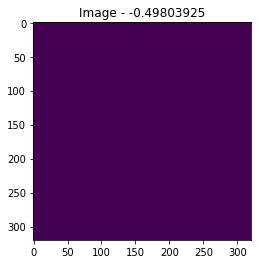

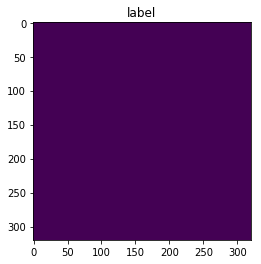

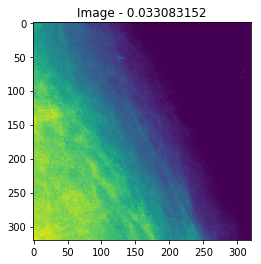

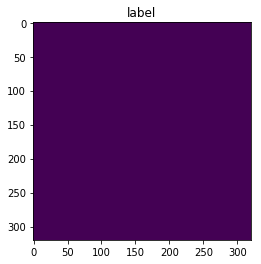

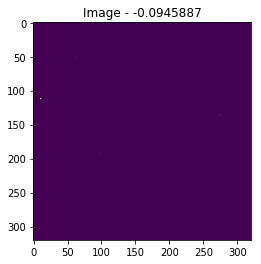

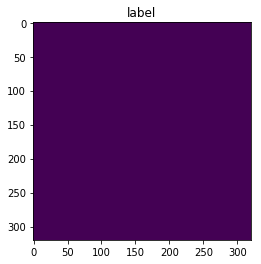

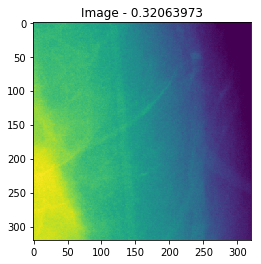

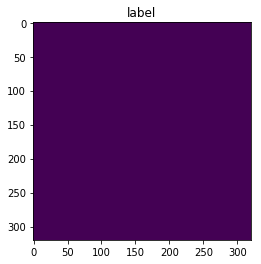

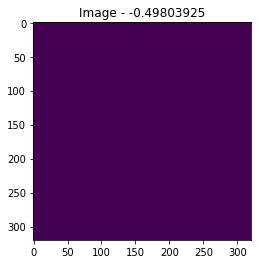

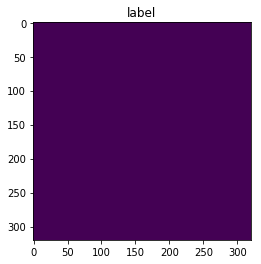

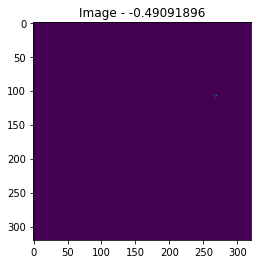

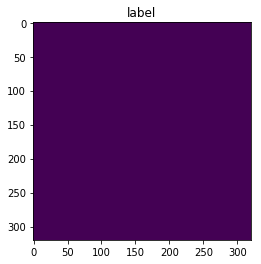

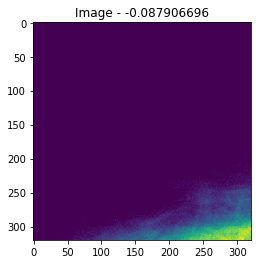

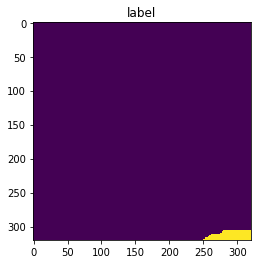

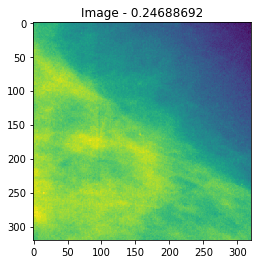

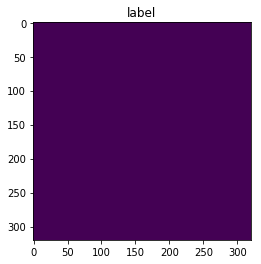

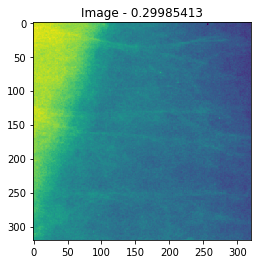

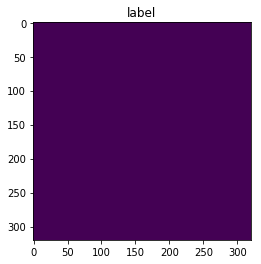

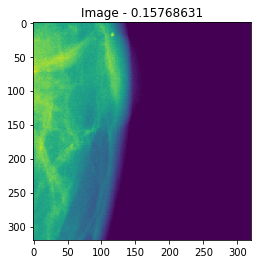

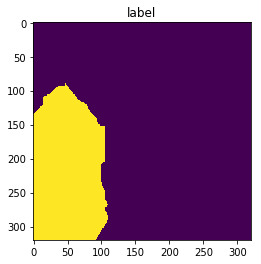

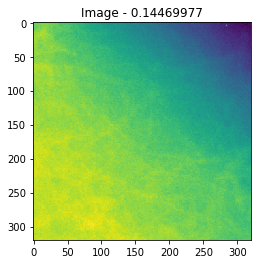

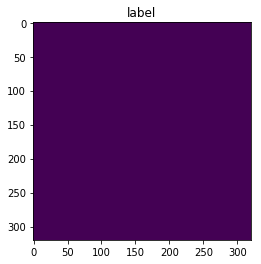

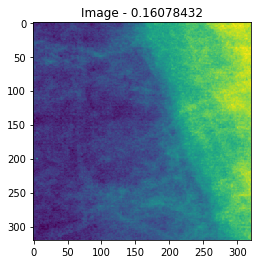

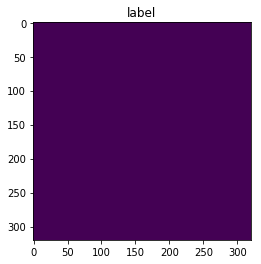

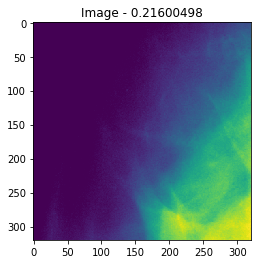

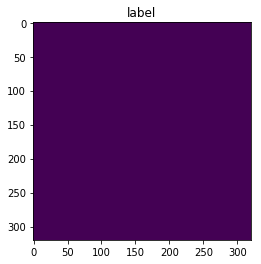

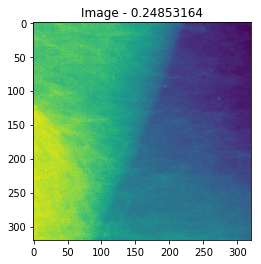

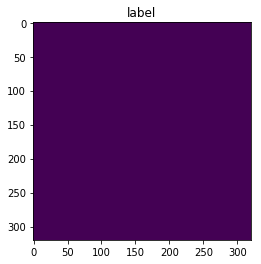

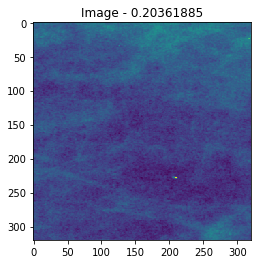

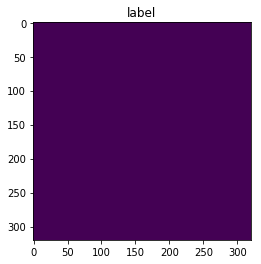

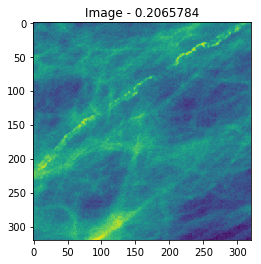

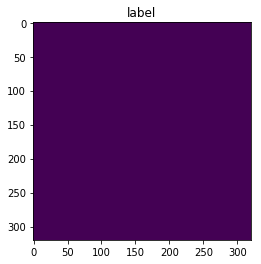

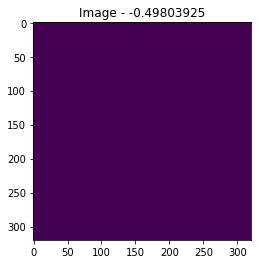

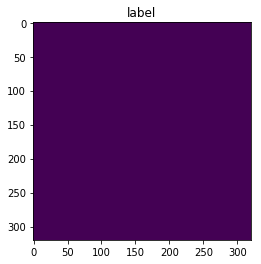

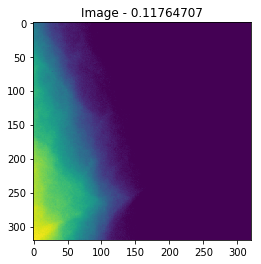

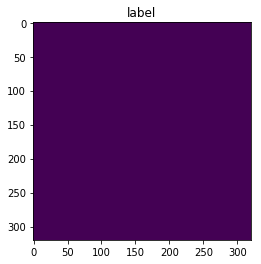

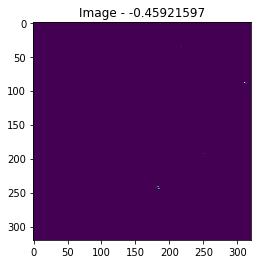

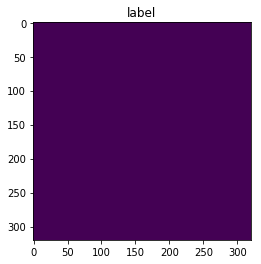

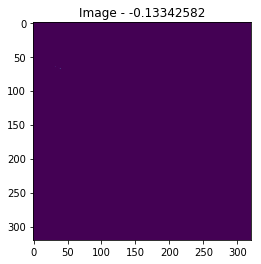

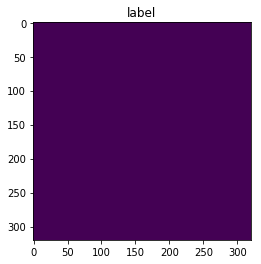

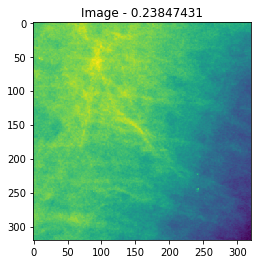

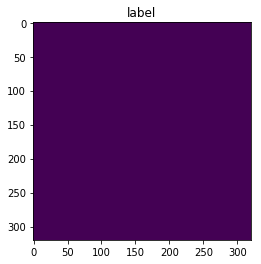

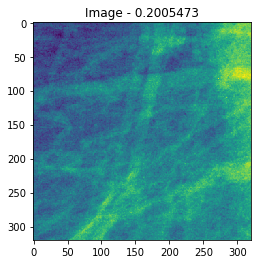

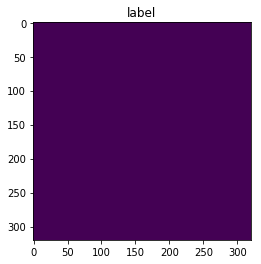

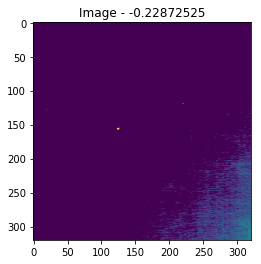

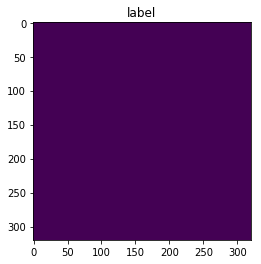

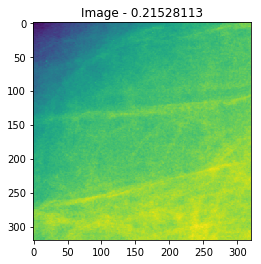

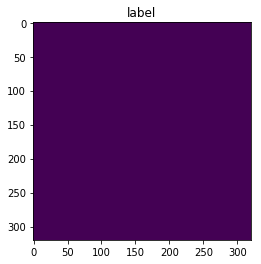

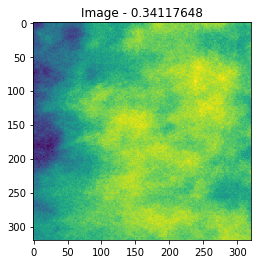

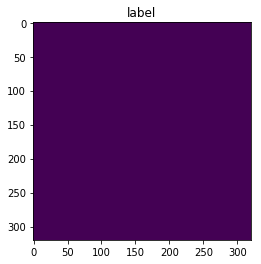

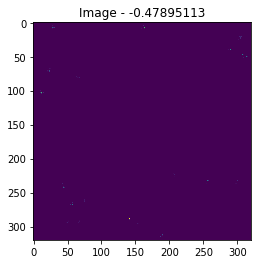

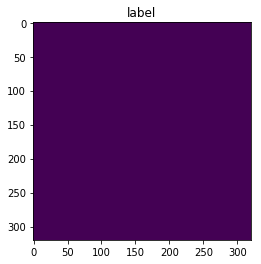

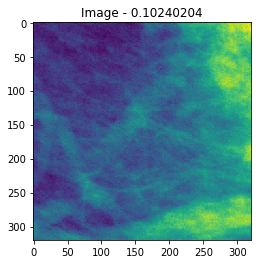

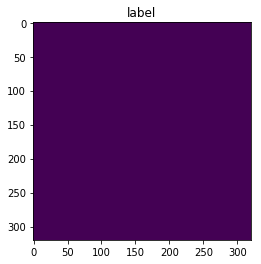

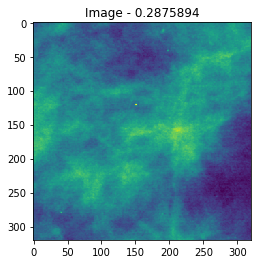

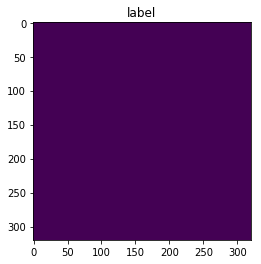

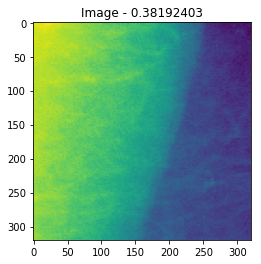

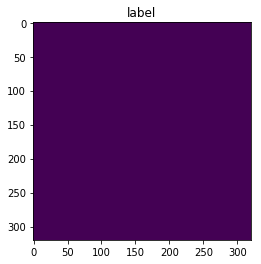

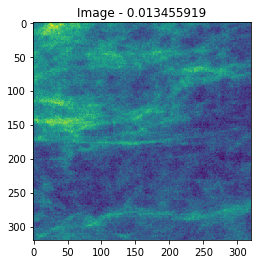

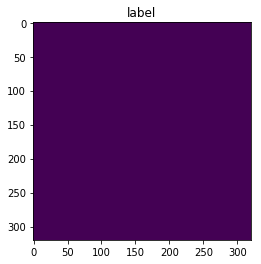

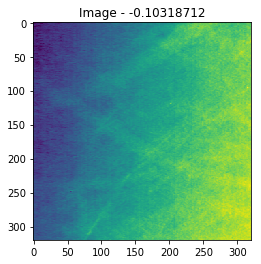

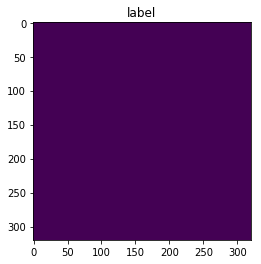

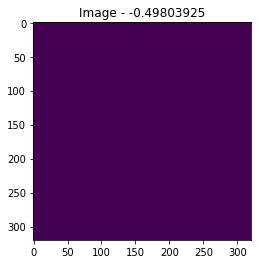

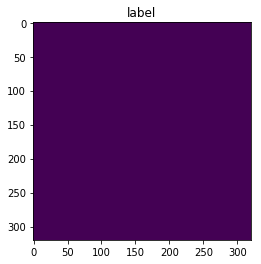

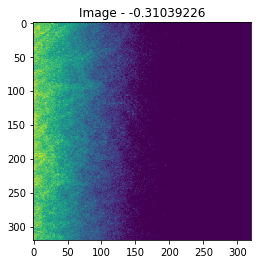

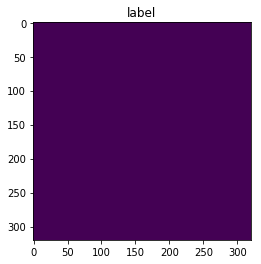

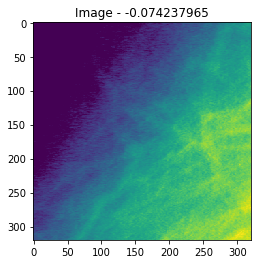

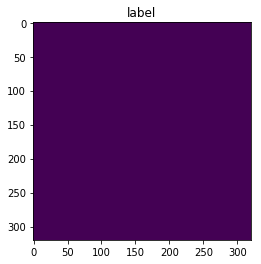

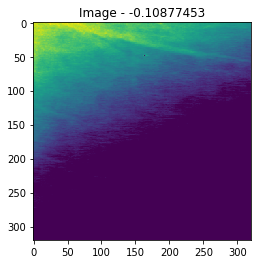

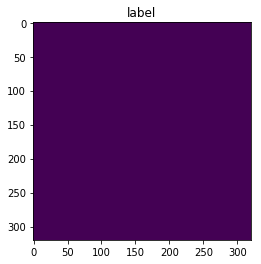

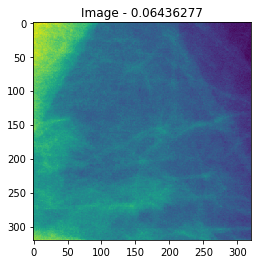

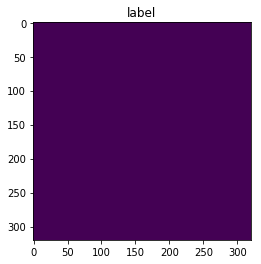

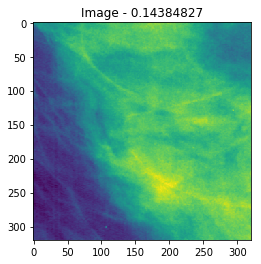

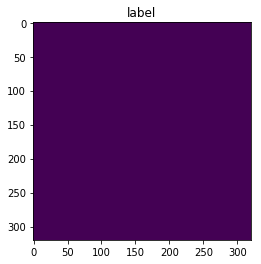

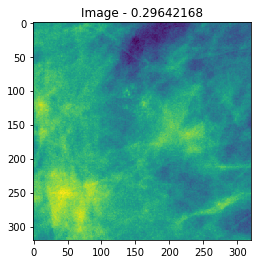

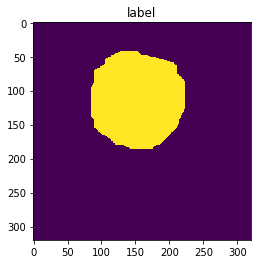

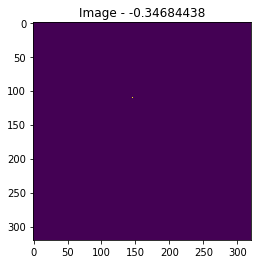

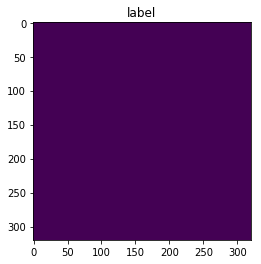

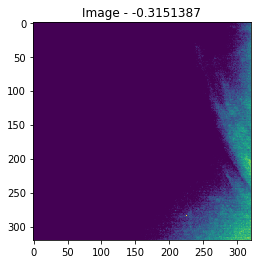

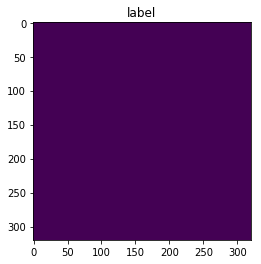

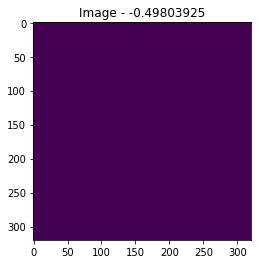

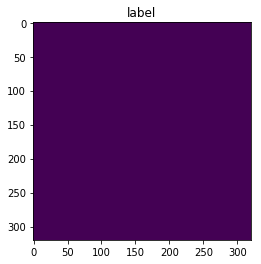

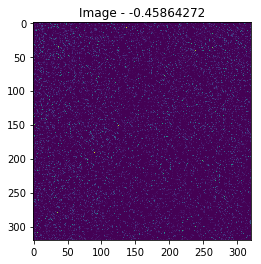

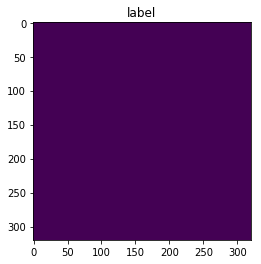

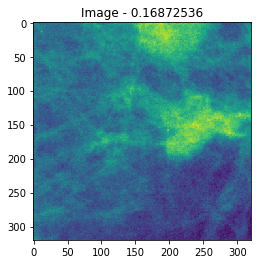

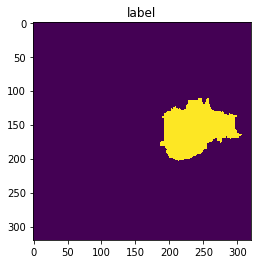

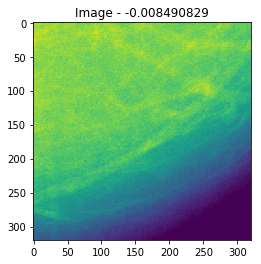

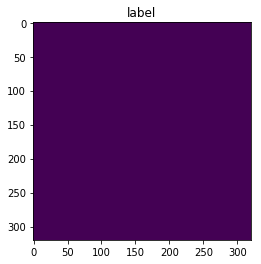

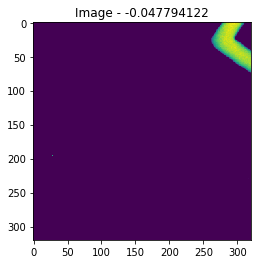

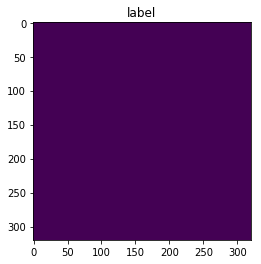

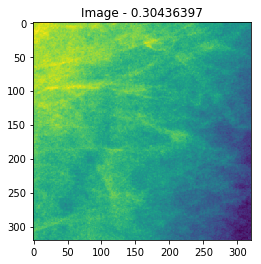

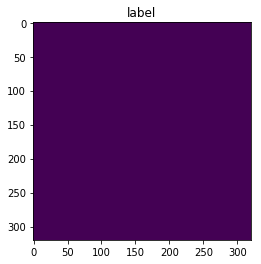

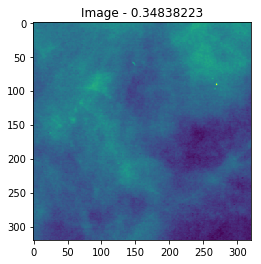

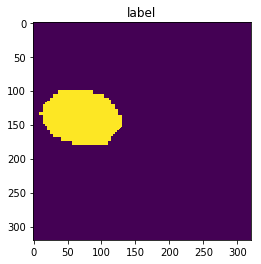

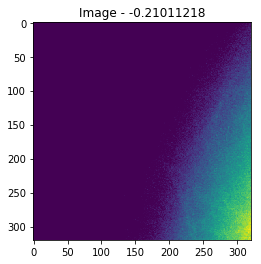

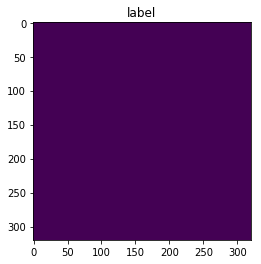

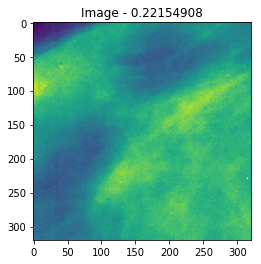

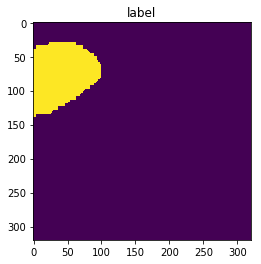

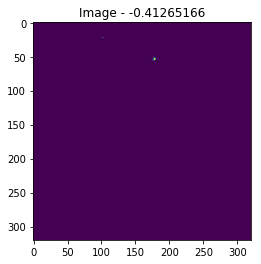

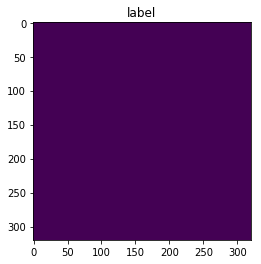

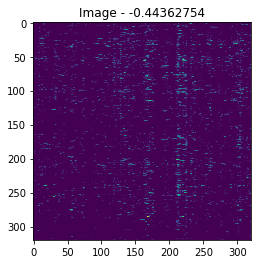

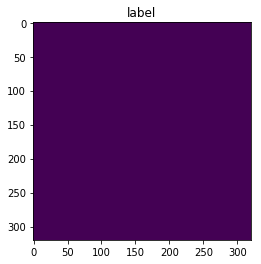

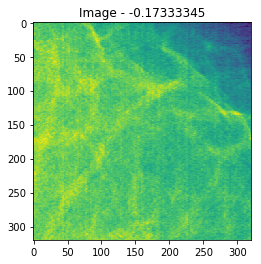

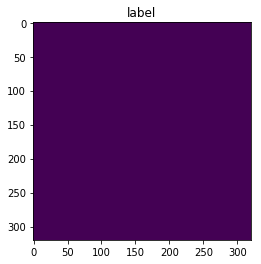

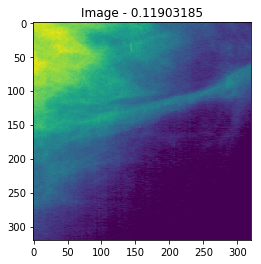

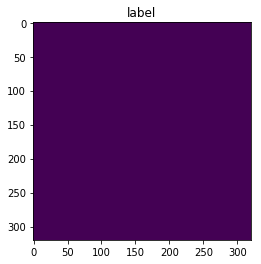

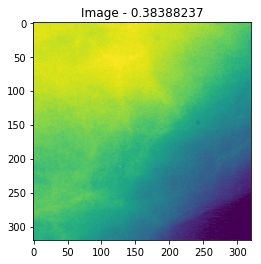

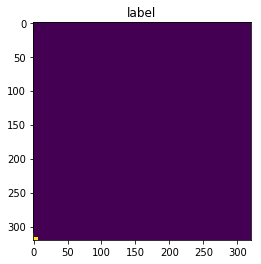

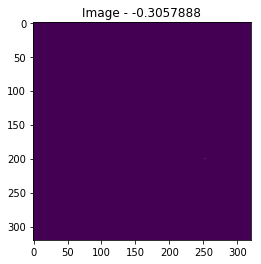

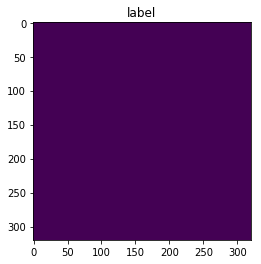

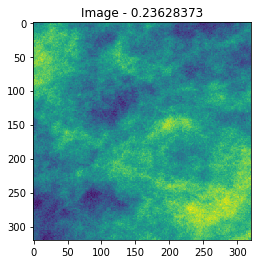

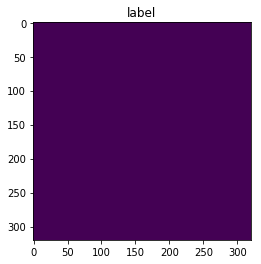

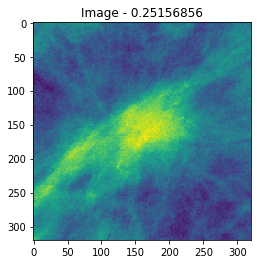

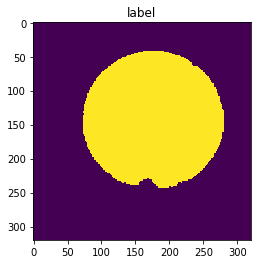

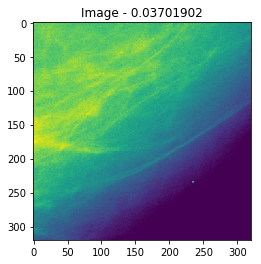

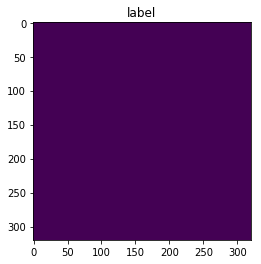

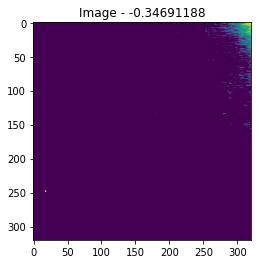

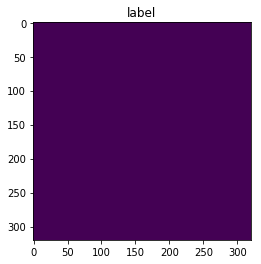

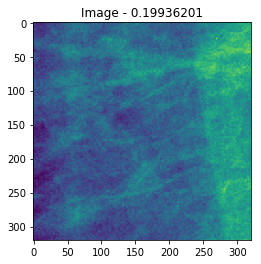

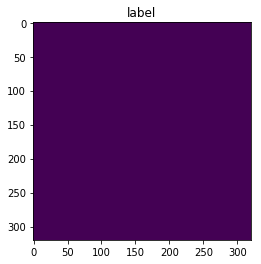

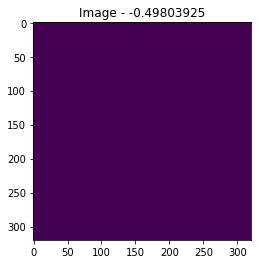

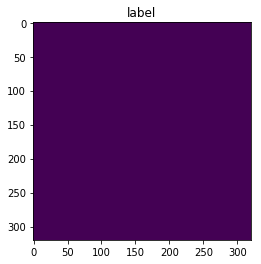

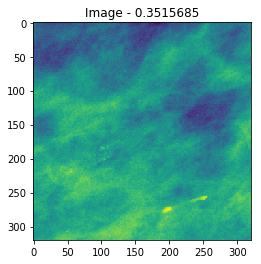

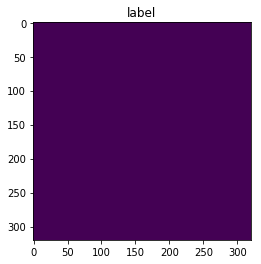

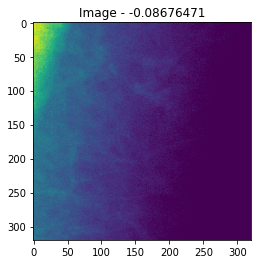

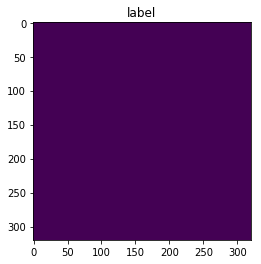

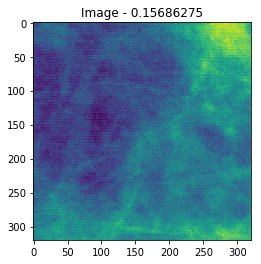

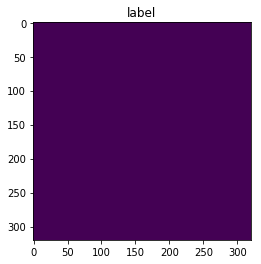

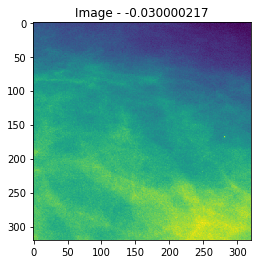

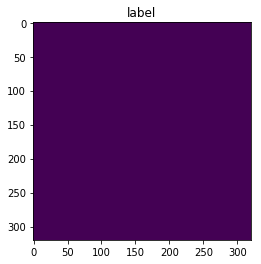

In [6]:
with tf.Session(graph=graph) as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for epoch in range(5):
        
        X_, y_ = sess.run([X_adj, y_def])
        
        for j in range(len(X_)):
            plt.imshow(np.squeeze(X_[j]))
            plt.title("Image - " + str(np.max(X_[j])))
            plt.show()
            
            plt.imshow(np.squeeze(y_[j]))
            plt.title("label")
            plt.show()
            
    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

In [26]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)

In [32]:
one = logloss(0, 0.4)
two = logloss(0, 0.5)
three = logloss(0, 0.5)
four = logloss(0, 0.6)

np.mean([one,two,three,four])

0.7033526791900091

In [34]:
foo = [18, 3, 15, 24]
foo / np.sum(foo)

array([0.3 , 0.05, 0.25, 0.4 ])

## Backup

In [3]:
def _create_image_list(image_dir):
    files = tf.convert_to_tensor(os.listdir(image_dir))
    return files

def read_my_file_format(filename):
    file_contents = tf.read_file(filename)
    image = tf.image.decode_png(file_contents)
    
    cropped_image = tf.random_crop(image, size=[size, size, 3])

    image = cropped_image[:, :, 0]
    label = cropped_image[:, :, 1]
    
    return image, label

image_list = _create_image_list("./data/train_images/")

input_queue = tf.train.slice_input_producer(image_list, num_epochs=None, shuffle=True)

image, label = read_my_file_format(input_queue.dequeue())

image_batch, label_batch = tf.train.batch([image, label], batch_size=16)


AttributeError: 'list' object has no attribute 'dequeue'

In [14]:


def _read_images_from_disk(input_queue, image_dir, size=640):
    image_string = tf.read_file(os.path.join(image_dir, input_queue))
    image_decoded = tf.image.decode_image(image_string)

    cropped_image = tf.random_crop(image_decoded, size=[size, size, 3])

    image = cropped_image[:, :, 0]
    label = cropped_image[:, :, 1]

    return image, label

def _create_image_queue(files):
    input_queue = tf.train.slice_input_producer(files,
                                            num_epochs=None,
                                            shuffle=True)
    
    image, label = _read_images_from_disk(input_queue.dequeue(), size=320)
    
    image_batch, label_batch = tf.train.batch([image, label], batch_size=batch_size)
    
    return image_batch, label_batch

In [16]:
os.listdir("./data/train_images/")

['P_00001_LEFT_CC_1.png',
 'P_00001_LEFT_MLO_2.png',
 'P_00004_LEFT_CC_3.png',
 'P_00004_LEFT_MLO_4.png',
 'P_00004_RIGHT_MLO_5.png',
 'P_00005_RIGHT_CC_6.png',
 'P_00005_RIGHT_MLO_7.png',
 'P_00007_LEFT_CC_8.png',
 'P_00007_LEFT_MLO_9.png',
 'P_00008_LEFT_CC_10.png',
 'P_00008_LEFT_MLO_11.png',
 'P_00008_RIGHT_CC_12.png',
 'P_00008_RIGHT_MLO_13.png',
 'P_00009_RIGHT_CC_14.png',
 'P_00009_RIGHT_MLO_15.png',
 'P_00010_LEFT_CC_16.png',
 'P_00010_LEFT_MLO_17.png',
 'P_00011_LEFT_CC_18.png',
 'P_00011_LEFT_MLO_19.png',
 'P_00012_LEFT_CC_20.png',
 'P_00012_LEFT_MLO_21.png',
 'P_00013_RIGHT_MLO_22.png',
 'P_00014_LEFT_CC_23.png',
 'P_00014_LEFT_MLO_24.png',
 'P_00015_LEFT_MLO_25.png',
 'P_00018_RIGHT_CC_30.png',
 'P_00018_RIGHT_MLO_31.png',
 'P_00019_RIGHT_CC_32.png',
 'P_00019_RIGHT_MLO_33.png',
 'P_00020_LEFT_CC_34.png',
 'P_00020_LEFT_MLO_35.png',
 'P_00021_LEFT_CC_36.png',
 'P_00021_LEFT_MLO_37.png',
 'P_00021_RIGHT_CC_38.png',
 'P_00021_RIGHT_MLO_39.png',
 'P_00022_LEFT_CC_40.png',
 'P_

In [13]:
files = _create_image_list("./data/train_images/")
X, y = _create_image_queue(files)

# Start a new session to show example output.
with tf.Session() as sess:
    # Required to get the filename matching to run.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Get an image tensor and print its value.
    image_tensor, label_tensor = sess.run([X, y])
    
    plt.imshow(image_tensor)
    plt.show()
    
    plt.imshow(label_tensor)
    plt.show()
    
    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

TypeError: Tensor objects are not iterable when eager execution is not enabled. To iterate over this tensor use tf.map_fn.

In [4]:
print(_create_image_list("./data/train_images/"))

Tensor("Const_1:0", shape=(2390,), dtype=string)


In [2]:
def _parse_function(filename, size=640):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)

    cropped_image = tf.random_crop(image_decoded, size=[size, size, 3])

    image = cropped_image[:, :, 0]
    label = cropped_image[:, :, 1]

    return image, label

def _get_dataset(image_dir, batch_size=16):
    filenames = tf.constant(os.listdir(image_dir))

    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    dataset = dataset.map(_parse_function).batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    image_batch, label_batch  = iterator.get_next()

    return image_batch, label_batch

In [24]:
X, y = _get_dataset("./data/train_images")

# Start a new session to show example output.
with tf.Session() as sess:
    # Required to get the filename matching to run.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Get an image tensor and print its value.
    image_tensor, label_tensor = sess.run([X, y])
    
    plt.imshow(image_tensor)
    plt.show()
    
    plt.imshow(label_tensor)
    plt.show()
    
    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_1/input_producer_1_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_1, input_producer_1/RandomShuffle)]]


NotFoundError: NewRandomAccessFile failed to Create/Open: P_00001_LEFT_CC_1.png : The system cannot find the file specified.
; No such file or directory
	 [[Node: ReadFile = ReadFile[](arg0)]]
	 [[Node: IteratorGetNext_3 = IteratorGetNext[output_shapes=[[?,640,640], [?,640,640]], output_types=[DT_UINT8, DT_UINT8], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_3)]]

In [ ]:
image, label = _read_images("./data/train_images/", crop_size=640)
batch_size = 8
X, y = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000, seed=None, min_after_dequeue=1000)

# Start a new session to show example output.
with tf.Session() as sess:
    # Required to get the filename matching to run.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
        # Get an image tensor and print its value.
        image_tensor, label_tensor = sess.run([X, y])

        plt.imshow(image_tensor[0])
        plt.show()

        plt.imshow(label_tensor[0])
        plt.show()
    
    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)


In [22]:
filenames = tf.train.string_input_producer(tf.train.match_filenames_once("./data/train_images/" + "*.png"), shuffle=True)

dataset = tf.data.Dataset.from_tensor_slices((filenames))
dataset = dataset.map(_parse_function).batch(16)
iterator = dataset.make_one_shot_iterator()
image_batch, label_batch  = iterator.get_next()

TypeError: Failed to convert object of type <class 'tensorflow.python.ops.data_flow_ops.FIFOQueue'> to Tensor. Contents: <tensorflow.python.ops.data_flow_ops.FIFOQueue object at 0x000002516B3A1E80>. Consider casting elements to a supported type.

In [2]:
def _parse_function(filename, size=640):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    
    cropped_image = tf.random_crop(image_decoded, size=[size, size, 3])
    
    image = cropped_image[:,:,0]
    label = cropped_image[:,:,1]
    
    return image, label

def _read_images(image_dir, crop_size):
    filenames = tf.train.match_filenames_once(image_dir + "*.png")
    filename_queue = tf.train.string_input_producer(filenames)

    # create the reader
    image_reader = tf.WholeFileReader()

    # Read a whole file from the queue
    filename, image_file = image_reader.read(filename_queue)

    # decode the image
    raw_image = tf.image.decode_png(image_file)
    
    # crop the image
    raw_image = tf.random_crop(raw_image, size=[crop_size, crop_size, 3])

    image = raw_image[:, :, 0]
    label = raw_image[:, :, 1]

    return image, label

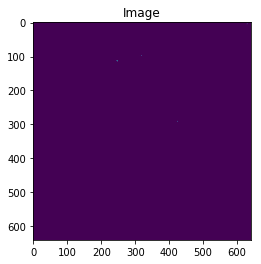

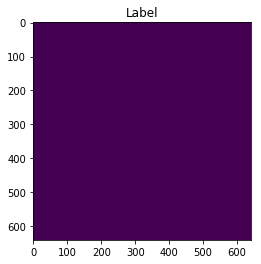

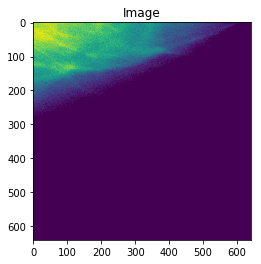

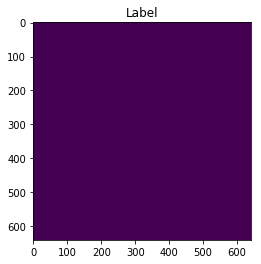

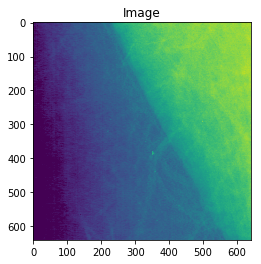

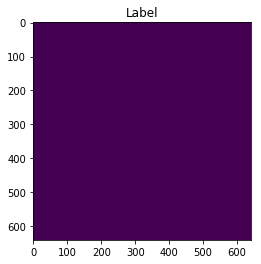

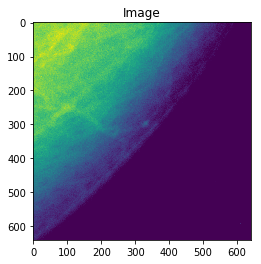

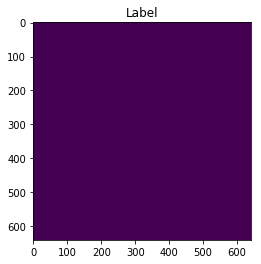

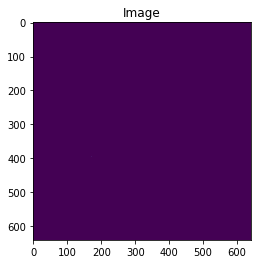

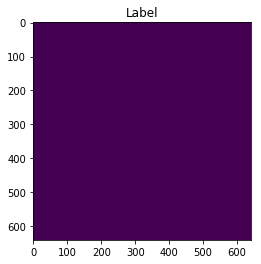

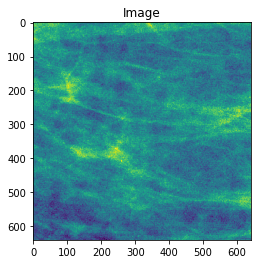

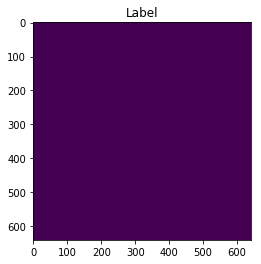

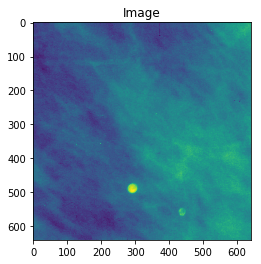

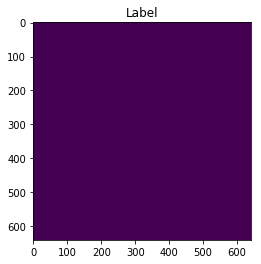

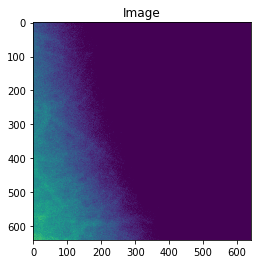

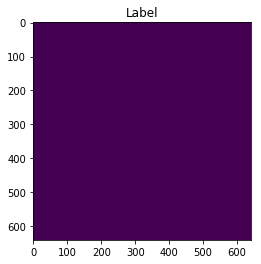

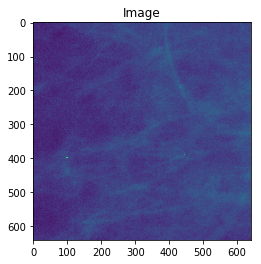

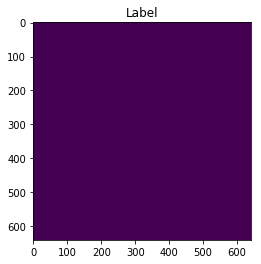

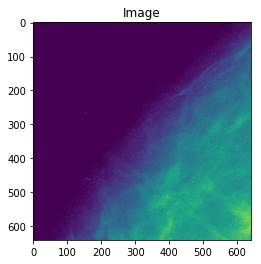

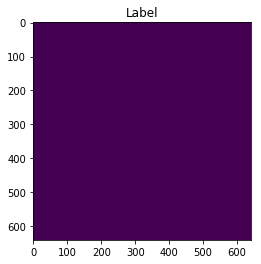

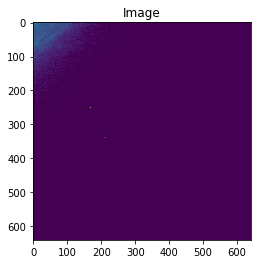

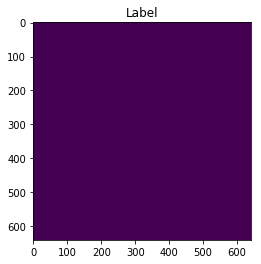

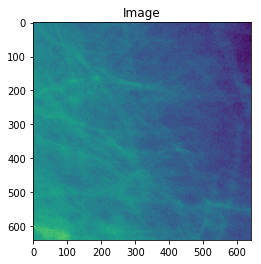

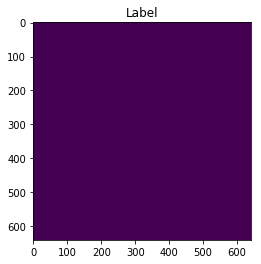

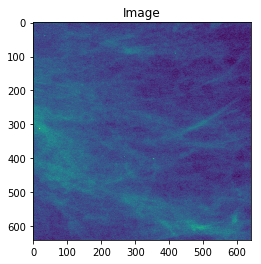

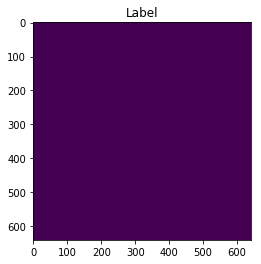

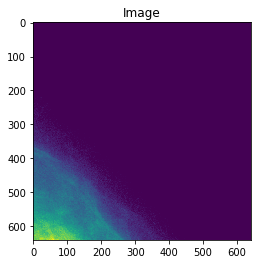

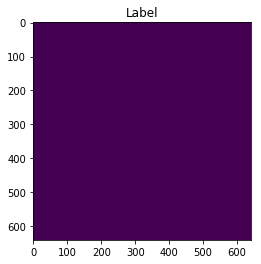

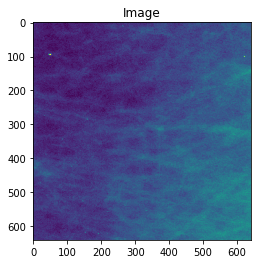

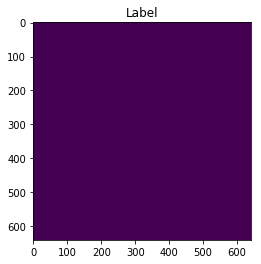

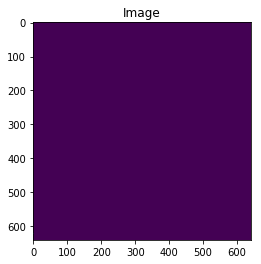

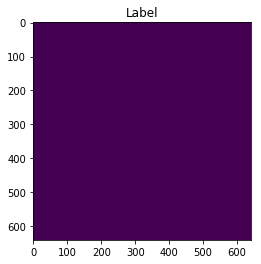

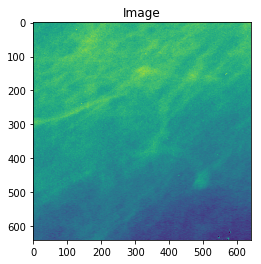

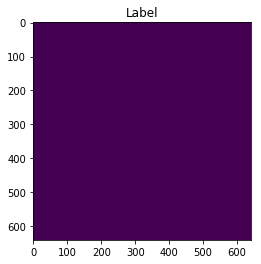

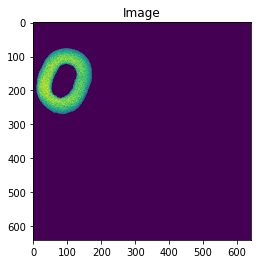

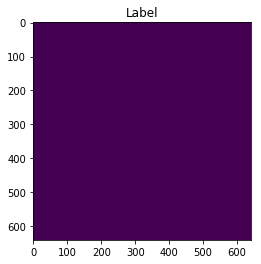

In [5]:
# create the queue
image, label = _read_images("./data/train_images/", 640)

X_def, y_def = tf.train.batch([image, label], batch_size=16)

# Start a new session to show example output.
with tf.Session() as sess:
    # Required to get the filename matching to run.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(3):
        # Get an image tensor and print its value.
        image_tensor, label_tensor = sess.run([X_def, y_def])
        
        for j in range(6):
            plt.imshow(np.squeeze(image_tensor[j]))
            plt.title("Image")
            plt.show()

            plt.imshow(np.squeeze(label_tensor[j]))
            plt.title("Label")
            plt.show()
    
    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)
